# **Efficient and Fast Sampling of Truncated Multivariate Gaussian Random Variables**

A More Detailed Survey with Python Implementations

----
## Table of Contents
1. [Introduction](#introduction)
2. [Basic Sampling Approaches](#basic)
3. [More Sophisticated MCMC](#sophisticated)
4. [Transformation-Based Approaches](#transformation)
5. [Higher-Dimensional Examples (3D)](#3d-examples)
6. [Combining Functions & Practical Guidelines](#combining)
7. [References](#references)

---

<a id="introduction"></a>
# 1. Introduction

Truncated multivariate Gaussian (TMG) distributions arise frequently in scenarios where some or all dimensions of a Gaussian random vector must remain within a specified region, \(\mathcal{A}\). Such constraints appear in *econometrics* (e.g., limited dependent variables), *signal processing* (physical amplitude constraints), and *Bayesian inference* (priors with bounded support).

### 1.1 Motivation and Mathematical Preliminaries

**Definition and Notation.** Let \(\mathbf{X} \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)\) be a \(d\)-dimensional Gaussian with mean vector \(\boldsymbol{\mu} \in \mathbb{R}^d\) and covariance matrix \(\Sigma \in \mathbb{R}^{d\times d}\). Suppose we impose a truncation set \(\mathcal{A} \subseteq \mathbb{R}^d\). The *truncated* distribution, denoted \(\mathbf{X}\mid\mathbf{X}\in \mathcal{A}\), has density:

$$
f(\mathbf{x}\mid \mathbf{X}\in \mathcal{A}) = \frac{\varphi_d(\mathbf{x};\,\boldsymbol{\mu}, \Sigma)}{\displaystyle\int_{\mathbf{z}\in \mathcal{A}} \varphi_d(\mathbf{z};\,\boldsymbol{\mu}, \Sigma)\, d\mathbf{z}}\quad\text{for } \mathbf{x} \in \mathcal{A},
$$

where \(\varphi_d\) is the usual \(d\)-dimensional Gaussian density. The denominator

$$
Z_{\mathcal{A}} = \int_{\mathbf{z}\in \mathcal{A}} \varphi_d(\mathbf{z};\,\boldsymbol{\mu}, \Sigma)\, d\mathbf{z}
$$

acts as a normalizing constant.

**Why is this challenging?**
- For \(\mathcal{A}\) described by multiple constraints or high dimensions, direct sampling is non-trivial.
- In many applications, \(\mathcal{A}\) is a hyperrectangle defined by lower and upper bounds, but it can also be defined by linear (or more general) inequalities.
- Efficient algorithms are needed for high dimension or strong correlations.


<a id="basic"></a>
# 2. Basic Sampling Approaches

We begin with simpler methods: *rejection sampling* and a *naive Gibbs* approach. These illustrate the main issues before moving to more advanced techniques.

## 2.1 Rejection Sampling

**Key Idea.**

1. Draw \(\mathbf{Y} \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)\).
2. If \(\mathbf{Y}\notin \mathcal{A}\), discard and repeat.

When \(\mathcal{A}\) is large relative to the main mass of \(\mathcal{N}(\boldsymbol{\mu}, \Sigma)\), acceptance is high and the procedure is quick. However, for narrow or high-dimensional truncations, acceptance can become very low.

**Mathematical Efficiency.** The expected number of draws before an acceptance is \(1 / p\), where \(p = \Pr(\mathbf{X}\in \mathcal{A})\). If \(\mathcal{A}\) is small, we waste many draws.

### Implementation Step 1: Helper Function
Below we define a small helper function to sample from a multivariate normal.

In [2]:
import numpy as np

def sample_multivariate_normal(mu, Sigma, size=1):
    """
    Draw samples from N(mu, Sigma).
    mu: 1D array of shape (d,)
    Sigma: 2D array of shape (d, d)
    size: number of samples
    """
    return np.random.multivariate_normal(mu, Sigma, size=size)

### Implementation Step 2: Rejection Sampler for 2D Truncation
We'll implement a 2D truncated Gaussian sampler with separate lower/upper bounds for each dimension.

In [3]:
def truncated_gaussian_rejection_2d(mu, Sigma, lower_bounds, upper_bounds, n_samples):
    """
    Rejection sampling for a 2D truncated Gaussian.
    mu: array-like of shape (2,) - mean
    Sigma: array-like of shape (2,2) - covariance
    lower_bounds: (low1, low2)
    upper_bounds: (high1, high2)
    n_samples: number of output samples we want
    
    Returns: (samples, acceptance_rate)
      where samples has shape (n_samples, 2)
    """
    samples = []
    attempts = 0
    while len(samples) < n_samples:
        # Step 1: Propose from untruncated
        cand = sample_multivariate_normal(mu, Sigma, size=1)[0]
        # Step 2: Check truncation
        if np.all(cand >= lower_bounds) and np.all(cand <= upper_bounds):
            samples.append(cand)
        attempts += 1
    samples = np.array(samples)
    acceptance_rate = n_samples / attempts
    return samples, acceptance_rate

**2D Demonstration**

(2D) Rejection sampling acceptance rate: 0.6816632583503749


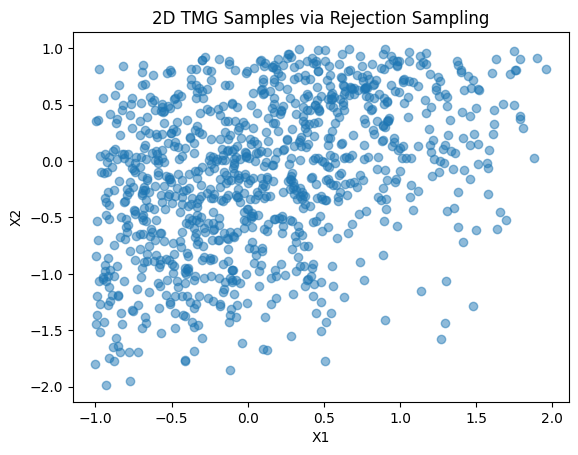

In [4]:
import matplotlib.pyplot as plt

# Example usage (2D)
mu_2d = np.array([0, 0])
Sigma_2d = np.array([[1.0, 0.6],
                     [0.6, 1.0]])
lb_2d = np.array([-1, -2])
ub_2d = np.array([ 2,  1])

samples_2d_reject, rate_2d = truncated_gaussian_rejection_2d(mu_2d, Sigma_2d, lb_2d, ub_2d, 1000)
print("(2D) Rejection sampling acceptance rate:", rate_2d)

plt.scatter(samples_2d_reject[:,0], samples_2d_reject[:,1], alpha=0.5)
plt.title("2D TMG Samples via Rejection Sampling")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

<a id="naive-gibbs"></a>
## 2.2 Naive Gibbs Sampling

**Idea.** Construct a Markov chain via coordinate-by-coordinate draws. For each dimension \(i\), sample \(X_i\) conditioned on the current values of the other coordinates. In a *naive* approach for 2D, we simply truncate each coordinate using the original bounds, ignoring more nuanced correlations. This can converge slowly under strong correlations.

**Intuition.** For the 2D case with bounds \(\mathbf{L} \le (X_1, X_2) \le \mathbf{U}\), each step samples \(X_1\mid X_2\), then \(X_2\mid X_1\). Conditionals of a Gaussian remain Gaussian, but we still do 1D truncation each step.


### Implementation Step 1: 1D Truncated Normal Sampler
A function to draw from a 1D truncated normal distribution via inverse transform sampling.

In [5]:
from scipy.stats import norm

def sample_truncnorm_1d(mean, var, lower, upper):
    """
    Sample from 1D truncated normal using inverse transform.
    mean: scalar
    var: scalar (variance)
    lower, upper: scalar bounds
    """
    sd = np.sqrt(var)
    
    # Convert to standard normal scale
    alpha = (lower - mean) / sd
    beta  = (upper - mean) / sd
    
    # Probability masses
    Phi_alpha = norm.cdf(alpha)
    Phi_beta  = norm.cdf(beta)
    
    # Uniform draw
    u = np.random.uniform(0, 1)
    u_star = Phi_alpha + u * (Phi_beta - Phi_alpha)
    
    # Invert standard normal CDF
    z = norm.ppf(u_star)
    
    return mean + sd * z

### Implementation Step 2: Naive Gibbs Sampler (2D)
We now implement the naive Gibbs approach in 2D by looping over coordinates.

In [6]:
def naive_gibbs_sampler_2d(mu, Sigma, lower_bounds, upper_bounds,
                           n_samples=1000, burn_in=200):
    """
    Naive 2D Gibbs sampler for truncated Gaussian with rectangular bounds.
    mu: (2,) mean
    Sigma: (2,2) covariance
    lower_bounds: (L1, L2)
    upper_bounds: (U1, U2)
    n_samples: total MCMC samples to store (post-burn-in)
    burn_in: number of burn-in iterations

    Returns: array of shape (n_samples, 2)
    """
    var_x1 = Sigma[0,0] - Sigma[0,1]*Sigma[1,0]/Sigma[1,1]
    var_x2 = Sigma[1,1] - Sigma[1,0]*Sigma[0,1]/Sigma[0,0]

    samples = []
    # Initialize at something in-bounds
    state = np.array([0.5*(lower_bounds[0] + upper_bounds[0]),
                      0.5*(lower_bounds[1] + upper_bounds[1])])

    for i in range(n_samples + burn_in):
        # Update X1 given X2
        mean_x1 = mu[0] + (Sigma[0,1]/Sigma[1,1])*(state[1] - mu[1])
        new_x1 = sample_truncnorm_1d(mean_x1, var_x1, lower_bounds[0], upper_bounds[0])
        state[0] = new_x1

        # Update X2 given X1
        mean_x2 = mu[1] + (Sigma[1,0]/Sigma[0,0])*(state[0] - mu[0])
        new_x2 = sample_truncnorm_1d(mean_x2, var_x2, lower_bounds[1], upper_bounds[1])
        state[1] = new_x2

        # After burn-in, record sample
        if i >= burn_in:
            samples.append(state.copy())

    return np.array(samples)

**2D Demonstration**

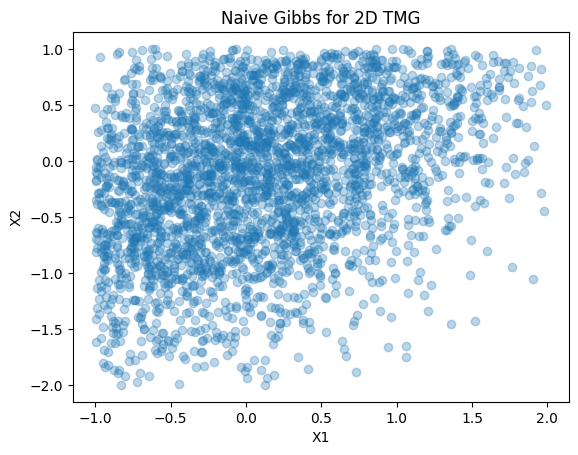

In [7]:
# Example usage with the same 2D scenario
gibbs_samples_naive_2d = naive_gibbs_sampler_2d(mu_2d, Sigma_2d, lb_2d, ub_2d, 3000, 500)

plt.scatter(gibbs_samples_naive_2d[:,0], gibbs_samples_naive_2d[:,1], alpha=0.3)
plt.title("Naive Gibbs for 2D TMG")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In practice, if correlation is high or the bounds are very tight, this naive Gibbs approach can exhibit strong autocorrelations in the chain.

<a id="sophisticated"></a>
# 3. More Sophisticated MCMC

We move to more advanced MCMC variants: a *refined coordinate-wise Gibbs* and *reflective Hamiltonian Monte Carlo (HMC)*. These can improve performance over naive methods.

## 3.1 Coordinate-wise Gibbs Sampling (Advanced)

**Improved Conditional.** For a multivariate Gaussian, the conditional \(X_i \mid \mathbf{X}_{-i}\) remains Gaussian:

$$
X_i \mid (X_j : j\neq i) \sim \mathcal{N}(\mu_{i| -i}, \sigma^2_{i| -i}),
$$

subject to truncation bounds. For a rectangular region, the bounds on \(X_i\) do not depend on the other coordinates (assuming the same dimension-wise intervals). This can be more efficient and accurately reflects the correlation each step.

In [8]:
def refined_gibbs_sampler_2d(mu, Sigma, lb, ub, n_samples=2000, burn_in=500):
    """
    An improved 2D Gibbs sampler for TMG with rectangular bounds.
    Explicitly computes conditionals each iteration.
    """
    # We'll just do a direct approach for 2D
    current = np.array([0.5*(lb[0]+ub[0]), 0.5*(lb[1]+ub[1])])
    chain = []
    
    for iteration in range(n_samples + burn_in):
        # Sample X1 | X2
        var_x1 = Sigma[0,0] - Sigma[0,1]*Sigma[1,0] / Sigma[1,1]
        mean_x1 = mu[0] + (Sigma[0,1]/Sigma[1,1])*(current[1] - mu[1])
        x1_new = sample_truncnorm_1d(mean_x1, var_x1, lb[0], ub[0])
        current[0] = x1_new

        # Sample X2 | X1
        var_x2 = Sigma[1,1] - Sigma[1,0]*Sigma[0,1] / Sigma[0,0]
        mean_x2 = mu[1] + (Sigma[1,0]/Sigma[0,0])*(current[0] - mu[0])
        x2_new = sample_truncnorm_1d(mean_x2, var_x2, lb[1], ub[1])
        current[1] = x2_new

        if iteration >= burn_in:
            chain.append(current.copy())

    return np.array(chain)

**2D Demonstration**

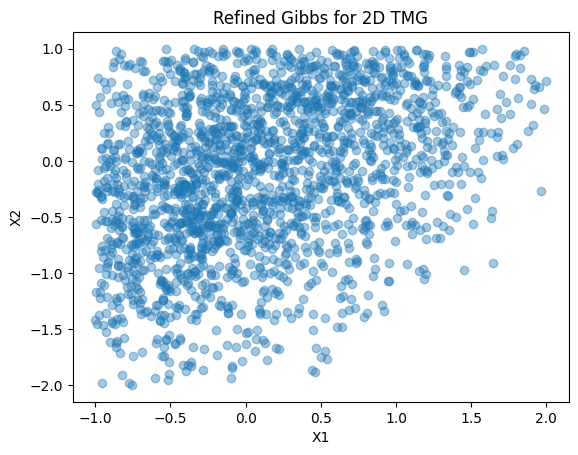

In [9]:
gibbs_samples_refined_2d = refined_gibbs_sampler_2d(mu_2d, Sigma_2d, lb_2d, ub_2d, 2000, 500)
plt.scatter(gibbs_samples_refined_2d[:,0], gibbs_samples_refined_2d[:,1], alpha=0.4)
plt.title("Refined Gibbs for 2D TMG")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## 3.2 Reflective Hamiltonian Monte Carlo (HMC)

**Motivation.** *Hamiltonian Monte Carlo* often explores correlated or high-dimensional spaces more effectively than coordinate-wise Gibbs. We treat position \(\mathbf{x}\) and momentum \(\mathbf{p}\), updating them using leapfrog steps. Upon hitting a boundary of \(\mathcal{A}\), we *reflect* the momentum rather than discarding or restarting.

**1D Sketch.** For 1D with interval \([L,U]\), the continuous update \(\dot{x} = p,\; \dot{p} = \nabla\log f(x)\) is integrated numerically. Whenever \(x\) tries to cross \(L\) or \(U\), we reflect:

$$
  x \leftarrow 2L - x \quad (\text{if crossing } L)\quad\text{and}\quad p \leftarrow -p,
$$

and similarly for the upper boundary.

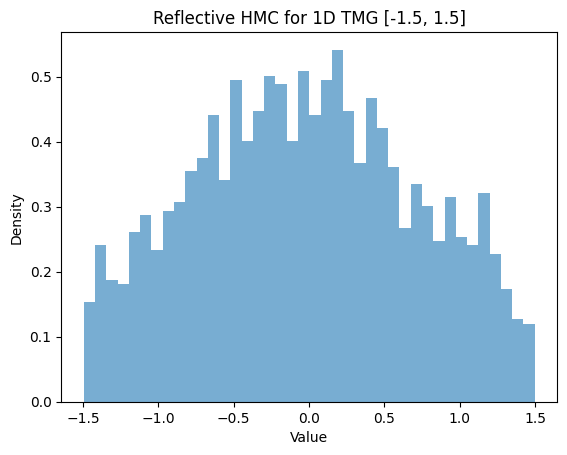

In [10]:
def log_gaussian_1d(x, mu=0.0, sigma=1.0):
    """ Unnormalized log-density of N(mu, sigma^2). """
    return -0.5 * ((x - mu)/sigma)**2

def grad_log_gaussian_1d(x, mu=0.0, sigma=1.0):
    """ Gradient of log-density w.r.t x. """
    return -(x - mu)/(sigma**2)

def reflective_hmc_1d(num_samples=1000, mu=0.0, sigma=1.0,
                      L=-2.0, U=2.0, step_size=0.05, n_leap=10):
    """
    Reflective HMC for a 1D truncated normal on [L, U].
    Simplified demonstration.
    """
    samples = []
    x = 0.5*(L + U)

    for i in range(num_samples):
        # sample momentum from standard Normal
        p = np.random.randn()
        
        # Half-step for momentum
        p += 0.5 * step_size * grad_log_gaussian_1d(x, mu, sigma)

        for _ in range(n_leap):
            x_new = x + step_size * p
            # reflection if out of bounds
            if x_new < L:
                x_new = 2*L - x_new
                p = -p
            elif x_new > U:
                x_new = 2*U - x_new
                p = -p
            x = x_new
            # if not last step, full step for momentum
            if _ < n_leap - 1:
                p += step_size * grad_log_gaussian_1d(x, mu, sigma)

        # final half-step
        p += 0.5 * step_size * grad_log_gaussian_1d(x, mu, sigma)
        samples.append(x)

    return np.array(samples)

# 1D demonstration
samples_hmc_1d = reflective_hmc_1d(num_samples=2000, mu=0, sigma=1,
                                   L=-1.5, U=1.5)
plt.hist(samples_hmc_1d, bins=40, density=True, alpha=0.6)
plt.title("Reflective HMC for 1D TMG [-1.5, 1.5]")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

<a id="transformation"></a>
# 4. Transformation-Based Approaches

An influential class of methods introduces transformations (factorization, pivoting, etc.) to reduce correlations and make sampling more efficient. Notably, **Botev (arXiv:1511.02736)** proposes a pivotal approach, factorizing \(\Sigma\) and sampling the standardized variables in sequence.

## 4.1 Botev's Approach (Simplified 2D)

**Core Idea.** Factor \(\Sigma = L L^T\) (Cholesky). Then define \(\mathbf{z} \sim \mathcal{N}(0, I)\) and transform back via \(\mathbf{x} = \boldsymbol{\mu} + L\mathbf{z}\). If we sample \(\mathbf{z}\) to respect the truncated bounds on \(\mathbf{x}\), we can reduce correlation in the draws.

In [11]:
def cholesky_factor(Sigma):
    """
    Compute the (unpivoted) Cholesky factor L where Sigma = L L^T.
    For numerical stability, pivoting may be used in higher dimensions.
    """
    return np.linalg.cholesky(Sigma)

### Simplified 2D Botev-Style Sampler

In [12]:
from scipy.stats import truncnorm

def botev_sampler_2d(mu, Sigma, lb, ub, n_samples=1000):
    """
    Simplified Botev approach for 2D TMG on [lb, ub].
    """
    L = cholesky_factor(Sigma)  # 2x2
    results = []

    for _ in range(n_samples):
        # z0 truncated
        a0 = (lb[0] - mu[0]) / L[0,0]
        b0 = (ub[0] - mu[0]) / L[0,0]
        z0 = truncnorm.rvs(a0, b0)

        # z1 truncated, depends on z0
        mean_part = mu[1] + L[1,0]*z0
        a1 = (lb[1] - mean_part)/L[1,1]
        b1 = (ub[1] - mean_part)/L[1,1]
        z1 = truncnorm.rvs(a1, b1)

        # Reconstruct final x0, x1
        x0 = mu[0] + L[0,0]*z0
        x1 = mean_part + L[1,1]*z1

        results.append([x0, x1])

    return np.array(results)

**2D Demonstration**

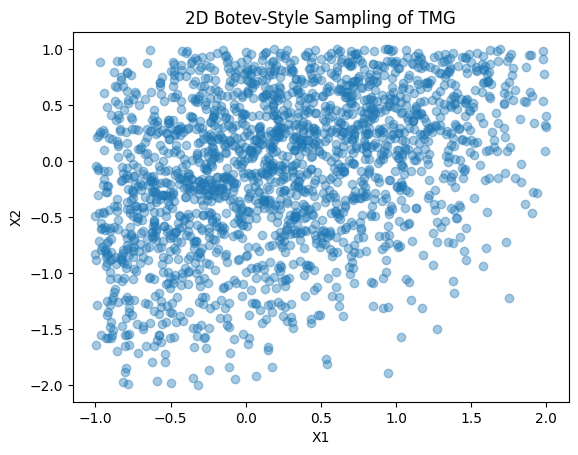

In [13]:
botev_samples_2d = botev_sampler_2d(mu_2d, Sigma_2d, lb_2d, ub_2d, n_samples=2000)
plt.scatter(botev_samples_2d[:,0], botev_samples_2d[:,1], alpha=0.4)
plt.title("2D Botev-Style Sampling of TMG")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

By sampling \(z_0\) and \(z_1\) in a carefully truncated manner, we often reduce correlation in the final sample compared to naive Gibbs.

<a id="3d-examples"></a>
# 5. Higher-Dimensional Examples (3D)

Here we demonstrate each method on a *3D truncated Gaussian* to illustrate how these methods scale beyond 2D. We'll use rectangular bounds in three dimensions, and for visualization, we'll make a 3D scatter plot.


## 5.1 Rejection Sampling (3D)

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def truncated_gaussian_rejection_3d(mu, Sigma, lb, ub, n_samples):
    """
    Rejection sampling for a 3D truncated Gaussian.
    mu: array-like of shape (3,)
    Sigma: array-like of shape (3,3)
    lb, ub: each shape (3,)
    n_samples: number of output samples
    """
    samples = []
    attempts = 0
    while len(samples) < n_samples:
        cand = sample_multivariate_normal(mu, Sigma, size=1)[0]
        if np.all(cand >= lb) and np.all(cand <= ub):
            samples.append(cand)
        attempts += 1
    return np.array(samples), n_samples/attempts

(3D) Rejection acceptance rate: 0.5978477481068155


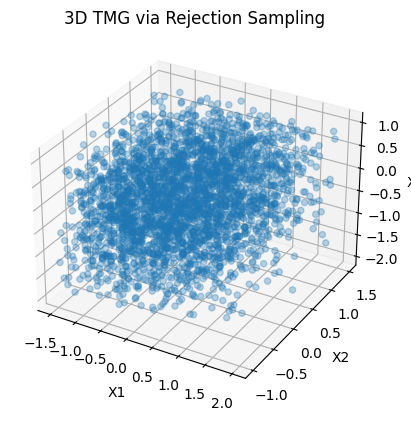

In [15]:
# Example usage (3D)
mu_3d = np.array([0.0, 0.0, 0.0])
Sigma_3d = np.array([[1.0, 0.3, 0.2],
                     [0.3, 1.0, 0.4],
                     [0.2, 0.4, 1.0]])
lb_3d = np.array([-1.5, -1.0, -2.0])
ub_3d = np.array([ 2.0,  1.5,  1.0])

samples_3d_reject, rate_3d = truncated_gaussian_rejection_3d(mu_3d, Sigma_3d, lb_3d, ub_3d, 3000)
print("(3D) Rejection acceptance rate:", rate_3d)

# 3D scatter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_3d_reject[:,0], samples_3d_reject[:,1], samples_3d_reject[:,2], alpha=0.3)
ax.set_title("3D TMG via Rejection Sampling")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()

## 5.2 Naive Gibbs Sampling (3D)
We'll generalize the naive Gibbs approach to 3D. We sequentially sample \(X_1\mid X_2,X_3\), then \(X_2\mid X_1,X_3\), then \(X_3\mid X_1,X_2\). Each conditional is still a truncated normal, though we'd need the correct conditional mean/variance.

In [16]:
def naive_gibbs_sampler_3d(mu, Sigma, lb, ub, n_samples=1000, burn_in=200):
    """
    Naive 3D Gibbs sampler (rectangular bounds) with fixed dimension-wise intervals.
    """
    d = 3
    samples = []
    # Initialize state in-bounds
    state = 0.5*(lb + ub)
    # Precompute inverse or partial conditionals if naive:

    # For each dimension, var(X_i|X_j, X_k) = Sigma[i,i] - (some correlation part)
    # We'll do an explicit approach for each coordinate for demonstration.

    for t in range(n_samples + burn_in):
        # Sample X1 given X2, X3
        # The conditional mean/var can be derived from standard multivariate Gaussian formulas.
        # For simplicity, let's do a direct block approach: Sigma_inv = np.linalg.inv(Sigma)
        # Then find the conditional formula. But naive approach might ignore cross-terms.

        Sigma_inv = np.linalg.inv(Sigma)
        # conditional variance for X1
        var_x1 = 1.0 / Sigma_inv[0,0]
        # conditional mean for X1 = mu1 + var_x1 * sum_{j != 0} [ -Sigma_inv[0,j]*(x_j - mu_j ) ]
        mean_x1 = mu[0]
        for j in range(1,3):
            mean_x1 -= Sigma_inv[0,j]*(state[j]-mu[j])
        mean_x1 *= var_x1

        new_x1 = sample_truncnorm_1d(mean_x1, var_x1, lb[0], ub[0])
        state[0] = new_x1

        # Sample X2 given X1, X3
        Sigma_inv = np.linalg.inv(Sigma)
        var_x2 = 1.0 / Sigma_inv[1,1]
        mean_x2 = mu[1]
        for j in [0,2]:
            mean_x2 -= Sigma_inv[1,j]*(state[j]-mu[j])
        mean_x2 *= var_x2

        new_x2 = sample_truncnorm_1d(mean_x2, var_x2, lb[1], ub[1])
        state[1] = new_x2

        # Sample X3 given X1, X2
        Sigma_inv = np.linalg.inv(Sigma)
        var_x3 = 1.0 / Sigma_inv[2,2]
        mean_x3 = mu[2]
        for j in [0,1]:
            mean_x3 -= Sigma_inv[2,j]*(state[j]-mu[j])
        mean_x3 *= var_x3

        new_x3 = sample_truncnorm_1d(mean_x3, var_x3, lb[2], ub[2])
        state[2] = new_x3

        if t >= burn_in:
            samples.append(state.copy())

    return np.array(samples)

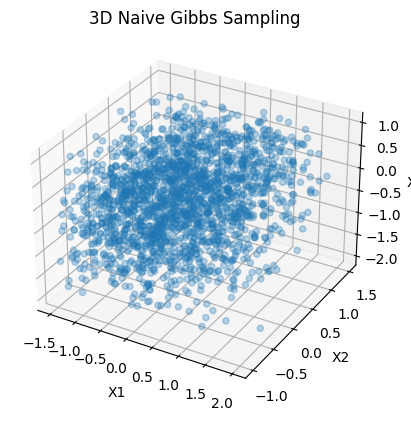

In [17]:
# Demonstration (3D naive Gibbs)
samples_3d_gibbs_naive = naive_gibbs_sampler_3d(mu_3d, Sigma_3d, lb_3d, ub_3d, 2000, 500)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_3d_gibbs_naive[:,0], samples_3d_gibbs_naive[:,1], samples_3d_gibbs_naive[:,2], alpha=0.3)
ax.set_title("3D Naive Gibbs Sampling")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()

## 5.3 Refined Gibbs (3D)
A more refined version would compute each conditional more directly. Implementation for 3D is conceptually the same, though more tedious to write out each formula for the conditionals. We'll do a straightforward approach using the standard MVN conditionals via the inverse of \(\Sigma\).

In [18]:
def refined_gibbs_sampler_3d(mu, Sigma, lb, ub, n_samples=1000, burn_in=200):
    """
    Refined 3D Gibbs sampler for truncated Gaussian.
    Uses the standard formula for conditionals: if Sigma_inv = (Sigma)^{-1},
    Var(X_i|others) = 1 / Sigma_inv[i,i],
    Mean(X_i|others) = mu[i] - (1 / Sigma_inv[i,i]) * sum_{j != i} Sigma_inv[i,j]*(X_j - mu[j]).
    """
    d = 3
    Sigma_inv = np.linalg.inv(Sigma)
    state = 0.5*(lb + ub)
    samples = []

    for t in range(n_samples + burn_in):
        for i in range(d):
            var_i = 1.0 / Sigma_inv[i,i]
            mean_i = mu[i]
            for j in range(d):
                if j != i:
                    mean_i -= Sigma_inv[i,j]*(state[j]-mu[j])
            mean_i *= var_i

            # draw truncated normal for X_i
            new_i = sample_truncnorm_1d(mean_i, var_i, lb[i], ub[i])
            state[i] = new_i

        if t >= burn_in:
            samples.append(state.copy())

    return np.array(samples)

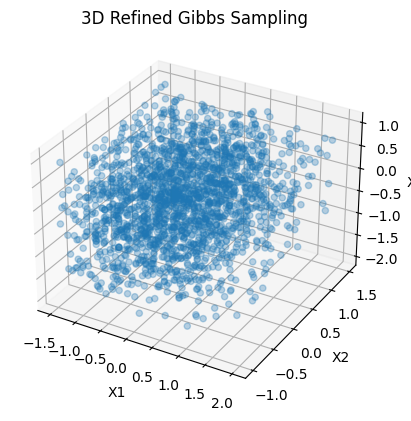

In [19]:
# Demonstration (3D refined Gibbs)
samples_3d_gibbs_refined = refined_gibbs_sampler_3d(mu_3d, Sigma_3d, lb_3d, ub_3d, 2000, 500)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_3d_gibbs_refined[:,0], samples_3d_gibbs_refined[:,1], samples_3d_gibbs_refined[:,2], alpha=0.3)
ax.set_title("3D Refined Gibbs Sampling")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()

## 5.4 Botev's Approach (3D)
We can similarly extend Botev's approach for 3D. Factor \(\Sigma = L L^T\), then sample \(z_0, z_1, z_2\) in sequence, respecting the truncated bounds in each step. Below is a simplified version that assumes purely rectangular bounding in each dimension.

In [20]:
def botev_sampler_3d(mu, Sigma, lb, ub, n_samples=1000):
    """
    Botev-style approach for 3D TMG. We'll do a naive sequential approach.
    """
    L = cholesky_factor(Sigma)
    results = []
    
    for _ in range(n_samples):
        # z0 truncated
        a0 = (lb[0] - mu[0]) / L[0,0]
        b0 = (ub[0] - mu[0]) / L[0,0]
        z0 = truncnorm.rvs(a0, b0)
        
        # z1
        mean_1_part = mu[1] + L[1,0]*z0
        a1 = (lb[1] - mean_1_part)/L[1,1]
        b1 = (ub[1] - mean_1_part)/L[1,1]
        z1 = truncnorm.rvs(a1, b1)
        
        # z2 depends on z0, z1
        # x2 = mu[2] + L[2,0]*z0 + L[2,1]*z1 + L[2,2]*z2
        # => z2 = (x2 - mu[2] - L[2,0]*z0 - L[2,1]*z1) / L[2,2]

        mean_2_part = mu[2] + L[2,0]*z0 + L[2,1]*z1
        a2 = (lb[2] - mean_2_part)/L[2,2]
        b2 = (ub[2] - mean_2_part)/L[2,2]
        z2 = truncnorm.rvs(a2, b2)
        
        # transform back
        x0 = mu[0] + L[0,0]*z0
        x1 = mean_1_part + L[1,1]*z1
        x2 = mean_2_part + L[2,2]*z2
        
        results.append([x0, x1, x2])
    
    return np.array(results)


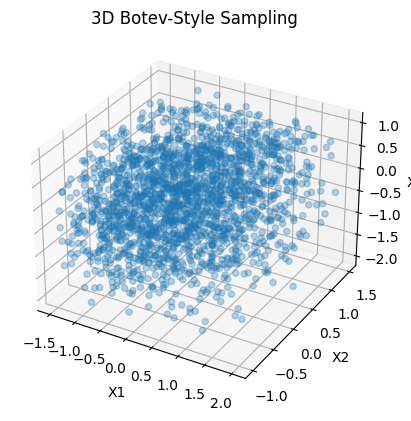

In [21]:
# Demonstration (3D Botev)
botev_samples_3d = botev_sampler_3d(mu_3d, Sigma_3d, lb_3d, ub_3d, n_samples=2000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(botev_samples_3d[:,0], botev_samples_3d[:,1], botev_samples_3d[:,2], alpha=0.3)
ax.set_title("3D Botev-Style Sampling")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()

<a id="combining"></a>
# 6. Combining Functions & Practical Guidelines

We now provide a single `main_sampler` function that picks a *2D method* as an illustration, and summarize practical advice. Extending it to 3D or higher is conceptually similar.


In [22]:
def main_sampler(method, mu, Sigma, lb, ub, n_samples=1000, burn_in=200):
    """
    A main entry point to different 2D sampling approaches.
    method: string in {"rejection", "naive_gibbs", "refined_gibbs", "botev"}
    mu, Sigma: distribution parameters
    lb, ub: lower/upper bound vectors for 2D
    n_samples: desired number of final samples
    burn_in: used only for MCMC methods
    """
    if method == "rejection":
        samples, rate = truncated_gaussian_rejection_2d(mu, Sigma, lb, ub, n_samples)
        print(f"[Rejection] acceptance rate: {rate:.3f}")
        return samples
    elif method == "naive_gibbs":
        return naive_gibbs_sampler_2d(mu, Sigma, lb, ub, n_samples, burn_in)
    elif method == "refined_gibbs":
        return refined_gibbs_sampler_2d(mu, Sigma, lb, ub, n_samples, burn_in)
    elif method == "botev":
        return botev_sampler_2d(mu, Sigma, lb, ub, n_samples)
    else:
        raise ValueError("Unknown method requested.")

**Example Usage** (2D, from `main_sampler`):

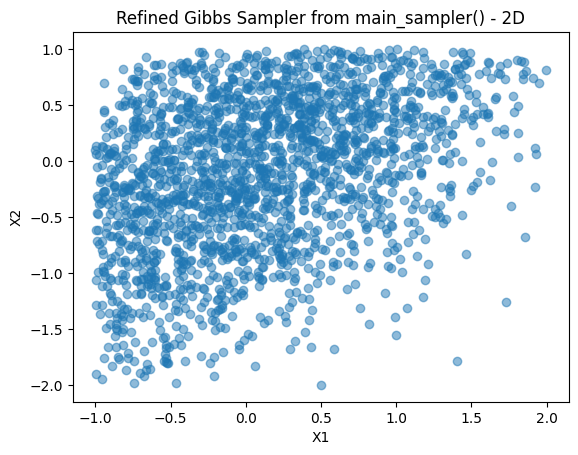

In [23]:
final_samples_2d = main_sampler("refined_gibbs", mu_2d, Sigma_2d, lb_2d, ub_2d, 2000, 500)
plt.scatter(final_samples_2d[:,0], final_samples_2d[:,1], alpha=0.5)
plt.title("Refined Gibbs Sampler from main_sampler() - 2D")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Practical Tips & Observations
- **Dimension Matters**: For \(d>10\), rejection sampling is generally impractical; MCMC or transformation-based methods become essential.
- **Bounds vs. Correlation**: The narrower the bounds or stronger the correlation, the more advanced methods (Gibbs, HMC, Botev) can outperform naive rejection.
- **Pivoting / Cholesky**: For stable factorization in higher dimensions, consider pivoted Cholesky or QR-based transforms.

**Conclusion.** The choice of method depends on dimensionality, truncation geometry, and correlation structure. The Python code presented can be adapted for specialized domains (e.g., Bayesian posteriors with bounded support, reliability problems, etc.).

<a id="references"></a>
# 7. References

1. Geweke, J. (1991). “Efficient simulation from the multivariate normal and Student-t distributions subject to linear constraints.” *Proceedings of the 23rd Symposium on the Interface*.
2. Gelfand, A. E., & Smith, A. F. M. (1990). “Sampling-based approaches to calculating marginal densities.” *Journal of the American Statistical Association*, 85(410), 398-409.
3. Hajivassiliou, V., McFadden, D., & Ruud, P. (1996). “Simulation of multivariate normal rectangle probabilities and their derivatives.” *Journal of Econometrics*, 72(1-2), 85-134.
4. Devroye, L. (1986). *Non-Uniform Random Variate Generation*. Springer.
5. Robert, C. P. (1995). “Simulation of truncated normal variables.” *Statistics and Computing*, 5(2), 121-125.
6. Casella, G., & Berger, R. L. (2002). *Statistical Inference*. Duxbury Press.
7. Tanner, M. A. (1996). *Tools for Statistical Inference*. Springer.
8. Chopin, N., & Robert, C. P. (2010). “Properties of nested sampling.” *Biometrika*, 97(3), 741-755.
9. Botev, Z. I. (2017). “The normal law under linear restrictions: simulation and estimation via minimum uncertainty distributions.” *arXiv preprint arXiv:1511.02736*.
10. Genz, A., & Bretz, F. (2009). *Computation of multivariate normal and t probabilities*. Springer.
11. Li, P., & Ghosh, S. (2015). “An efficient sampling method for truncated multivariate normal distributions.” *Journal of Statistical Computation and Simulation*, 85(7), 1390-1402.
12. Chevalier, C., & Ginsbourger, D. (2013). “Fast computation of the multi-points expected improvement with applications in batch selection.” In *Learning and Intelligent Optimization* (pp. 59-69). Springer.
13. Various discussions on coding/math forums (CrossValidated, GitHub, etc.).
14. Robert, C., & Casella, G. (2004). *Monte Carlo Statistical Methods*. Springer.
15. Chib, S., & Greenberg, E. (1995). “Understanding the Metropolis–Hastings algorithm.” *The American Statistician*, 49(4), 327-335.
16. Mengersen, K., Robert, C., & Titterington, D. (Eds.). (2011). *Mixtures: Estimation and Applications*. John Wiley & Sons.
